In [1]:
import numpy as np
import os
from mnist_web import mnist
train_images, train_labels, test_images, test_labels = mnist(path=os.path.join(os.getcwd(), "mnist"))

In [27]:
print("Training Images:", train_images.shape)
print("Training Labels:", train_labels.shape)
print("Testing Images:", test_images.shape)
print("Testing Labels:", test_labels.shape)

Training Images: (60000, 784)
Training Labels: (60000, 10)
Testing Images: (10000, 784)
Testing Labels: (10000, 10)


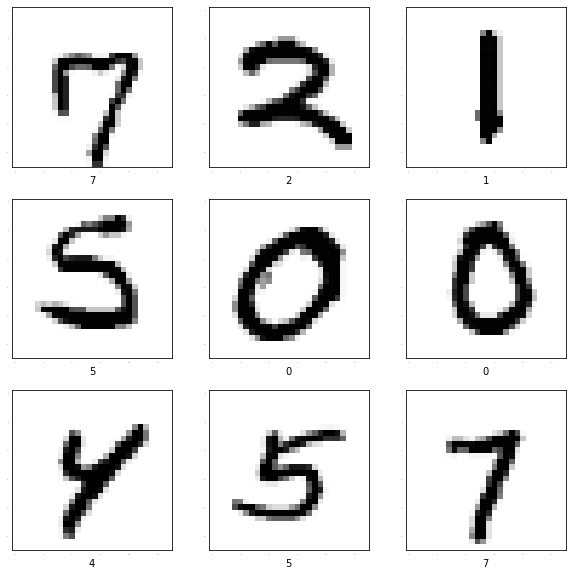

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(9):
    index = np.random.randint(0, 60000)
    plt.subplot(3,3,i+1)
    plt.tick_params(axis='both', labelsize=0, length=0)
    plt.grid(False)
    plt.imshow(train_images[index].reshape((28,28)), cmap='Greys')
    plt.xlabel(np.argmax(train_labels[index]))
plt.show()

In [28]:
def init_weights(L_in, L_out, epsilon_init=0.1):
    weights = np.random.random((L_out, L_in + 1))
    weights *= (2 * epsilon_init)
    weights -= epsilon_init
    return weights

In [29]:
def relu_gradient(z):
    z[z >= 0] = 1
    z[z < 0] = 0
    return z

In [61]:
from scipy.special import softmax


def cost(Theta, images, labels, reg_param):
    # turn theta vector into matrices
    Theta1 = Theta[:78500].reshape((100, 785))
    Theta2 = Theta[78500:88600].reshape((100, 101))
    Theta3 = Theta[88600:98700].reshape((100, 101))
    Theta4 = Theta[98700:].reshape((10, 101))
    
    # ensures we don't take log(0)
    log_epsilon = 1e-6
    
    # 60000 = entire training set
    batch_size = 60000
    
    cost = 0
    
    for i in range(batch_size):
        x = images[i]
        y = labels[i]
        
        #--feed-forward--#
        
        a1 = np.insert(x, 0, 1)

        z2 = Theta1 @ a1
        # relu activation
        a2 = z2
        a2[a2 < 0] = 0
        a2 = np.insert(a2, 0, 1)
        
        z3 = Theta2 @ a2
        a3 = z3
        a3[a3 < 0] = 0
        a3 = np.insert(a3, 0, 1)
        
        z4 = Theta3 @ a3
        a4 = z4
        a4[z4 < 0] = 0
        a4 = np.insert(a4, 0, 1)
        
        z5 = Theta4 @ a4
        h_theta = softmax(z5)
        
        cost -= sum((np.multiply(y, np.log(h_theta + log_epsilon))) + (np.multiply((1 - y), np.log(1 - h_theta + log_epsilon)))) / batch_size

    # regulatization term
    cost += (sum(Theta1[:,1:].flatten() ** 2) + sum(Theta2[:,1:].flatten())+ sum(Theta3[:,1:].flatten())+ sum(Theta4[:,1:].flatten())) * (reg_param / (4 * batch_size))
    
#     print(cost)
    return cost


def gradient(Theta, images, labels, reg_param):
    # turn theta vector into matrices
    Theta1 = Theta[:78500].reshape((100, 785))
    Theta2 = Theta[78500:88600].reshape((100, 101))
    Theta3 = Theta[88600:98700].reshape((100, 101))
    Theta4 = Theta[98700:].reshape((10, 101))
    
    # initialize gradients with zeros
    Theta1_Grad = np.zeros(Theta1.shape)
    Theta2_Grad = np.zeros(Theta2.shape)
    Theta3_Grad = np.zeros(Theta3.shape)
    Theta4_Grad = np.zeros(Theta4.shape)
    
    # 60000 means we are computing the average gradient over the entire training set
    batch_size = 60000
        
    for i in range(batch_size):
        x = images[i]
        y = labels[i]
        
        #--feed-forward--#
        
        a1 = np.insert(x, 0, 1)

        z2 = Theta1 @ a1
        # relu activation
        a2 = z2
        a2[a2 < 0] = 0
        a2 = np.insert(a2, 0, 1)
        
        z3 = Theta2 @ a2
        a3 = z3
        a3[a3 < 0] = 0
        a3 = np.insert(a3, 0, 1)
        
        z4 = Theta3 @ a3
        a4 = z4
        a4[z4 < 0] = 0
        a4 = np.insert(a4, 0, 1)
        
        z5 = Theta4 @ a4
        h_theta = softmax(z5)
        
#         z3 = Theta2 @ a2
#         # softmax activation
#         h_theta = softmax(z3)
        
        #--backpropagation--#
        
        delta5 = h_theta - y
        delta4 = np.multiply((delta5 @ Theta4)[1:], relu_gradient(z4))
        delta3 = np.multiply((delta4 @ Theta3)[1:], relu_gradient(z3))
        delta2 = np.multiply((delta3 @ Theta2)[1:], relu_gradient(z2))
        
#         delta3 = h_theta - y
#         delta2 = np.multiply((delta3 @ Theta2)[1:], relu_gradient(z2))
        
        Theta1_Grad += (delta2.reshape((delta2.size, 1)) @ a1.reshape((1, a1.size))) / batch_size
        Theta2_Grad += (delta3.reshape((delta3.size, 1)) @ a2.reshape((1, a2.size))) / batch_size
        Theta3_Grad += (delta4.reshape((delta4.size, 1)) @ a3.reshape((1, a3.size))) / batch_size
        Theta4_Grad += (delta5.reshape((delta5.size, 1)) @ a4.reshape((1, a4.size))) / batch_size

    # regularization
    Theta1_Grad[:,1:] += (reg_param / batch_size) * Theta1[:,1:]
    Theta2_Grad[:,1:] += (reg_param / batch_size) * Theta2[:,1:]
    Theta3_Grad[:,1:] += (reg_param / batch_size) * Theta3[:,1:]
    Theta4_Grad[:,1:] += (reg_param / batch_size) * Theta4[:,1:]
    
    # unroll gradient matrices into one long vector
    gradient = np.hstack((Theta1_Grad.flatten(), Theta2_Grad.flatten(), Theta3_Grad.flatten(), Theta4_Grad.flatten())).reshape((99710, 1))
    
    return gradient


def numerical_gradient(Theta, images, labels, reg_param):
    num_grad = np.zeros(Theta.shape)
    perturb = np.zeros(Theta.shape)
    epsilon = 1e-4
    
    for i in range(Theta.size):
        perturb[i] = epsilon
        
        cost1 = cost(Theta - perturb, images, labels, reg_param)
        cost2 = cost(Theta + perturb, images, labels, reg_param)
        
        num_grad[i] = (cost2 - cost1) / (2 * epsilon)
        
        perturb[i] = 0
        
    return num_grad
        

In [62]:
# initialize weights with random values
Theta1 = init_weights(784, 100)
Theta2 = init_weights(100, 100)
Theta3 = init_weights(100, 100)
Theta4 = init_weights(100, 10)

Theta = np.hstack((Theta1.flatten(), Theta2.flatten(), Theta3.flatten(), Theta4.flatten())).reshape((99710, 1))

grad = gradient(Theta, train_images, train_labels, reg_param=0)
num_grad = numerical_gradient(Theta, train_images, train_labels, reg_param=0)

KeyboardInterrupt: 

In [57]:
from scipy.optimize import minimize

# initialize weights with random values
Theta1 = init_weights(784, 100)
Theta2 = init_weights(100, 100)
Theta3 = init_weights(100, 100)
Theta4 = init_weights(100, 10)

# unroll weight matrices into one long vector
Theta = np.hstack((Theta1.flatten(), Theta2.flatten(), Theta3.flatten(), Theta4.flatten())).reshape((99710, 1))

# typically called lambda, but lambda is a python keyword
reg_param = 1.0

# optimize theta using the L-BFGS-B algorithm (low memory usage approximation of BFGS)
res = minimize(fun=cost, x0=Theta, method="L-BFGS-B", jac=gradient, args=(train_images, train_labels, reg_param), options={"disp": True, "maxiter": 50})

Theta = res.x.flatten()

# final parameters
Theta1 = Theta[:78500].reshape(Theta1.shape)
Theta2 = Theta[78500:88600].reshape(Theta2.shape)
Theta3 = Theta[88600:98700].reshape(Theta3.shape)
Theta4 = Theta[98700:].reshape(Theta4.shape)

3.2530955174254683
3.1929602263156194
3.0749321102153213
4.36615125155839
3.057452099943469
3.0524465374739553
3.3330843572479023
3.057091996664067
3.052792434147321
3.0524465374739553
4.061173582745501
2.9538952115879535
2.979247342940581
2.9502621897804064
2.959893040547051
2.9498910064770283
2.954184597791213
2.9498910064770283
11.965198699287836
3.877107717469024


KeyboardInterrupt: 

In [44]:
correct_count = 0
incorrect = []
for i in range(10000):
    x = test_images[i]
    y = test_labels[i]

    a1 = np.insert(x, 0, 1)

    z2 = Theta1 @ a1
    # relu activation
    a2 = z2
    a2[a2 < 0] = 0
    a2 = np.insert(a2, 0, 1)

    z3 = Theta2 @ a2
    # softmax activation
    h_theta = softmax(z3)
    
    if np.argmax(h_theta) == np.argmax(y):
        correct_count += 1
    else:
        incorrect.append((i, "Guess: {}, Correct: {}".format(np.argmax(h_theta), np.argmax(y))))

print("Test accuracy:", correct_count / 10000)
print("Incorrect:", len(incorrect_indices))

Test accuracy: 0.9407
Incorrect: 593


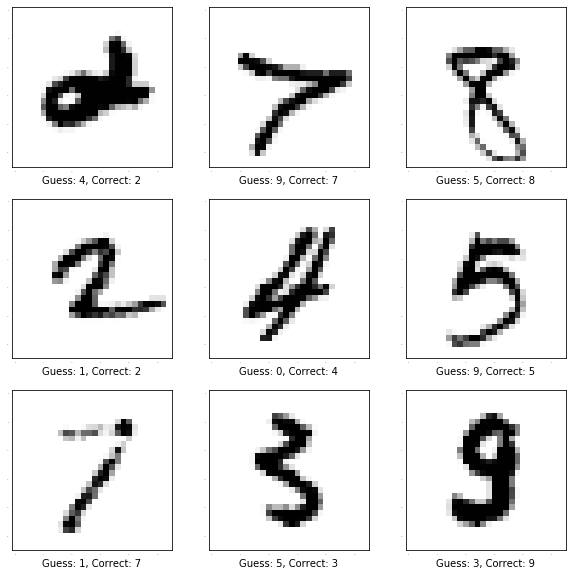

In [45]:
from random import sample

samples = sample(incorrect, 9)

plt.figure(figsize=(10,10))
for i in range(9):
    index = samples[i][0]
    plt.subplot(3,3,i+1)
    plt.tick_params(axis='both', labelsize=0, length=0)
    plt.grid(False)
    plt.imshow(test_images[index].reshape((28,28)), cmap='Greys')
    plt.xlabel(samples[i][1])
plt.show()